Once the audio clips have been selected, selected, and narrowed down, these clips are sent through the different ASRs and the outputs from these ASRs are obtained. Further, the clips are annotated by human annotators (two humans per clip). Finally, these human annotations are compared with the various ASR annotations.

Places that can be improved:
* Normalization of the transcriptions can be done a bit more carefully. 
    * Dealing with the `<UNKNOWN>` tags, which may span multiple words and affect WER negatively
    * Dealing with numbers... Some humans and some ASRs transcribed numerics inconsistently, transcribing as 'two' or 2 depending on the situation. Need a better way to normalize these.

In [2]:
import os
import pandas as pd
import re
import csv
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

# Set color palette to ORCA palette
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#68829D', '#329B8A', '#D24437', '#F5B100', '#62ABB9', '#A3B100'])


# Collect all transcriptions

## Original Audio Files

In [19]:
DIR_NAME = '/home/ubuntu/big_volume/covid_clips_after_segmenting'
covid_segments = os.listdir(DIR_NAME)

In [20]:
len(covid_segments)

335

## Human Transcriptions

In [26]:
human_segments = pd.read_csv('data/label_studio_transcriptions_12_09_2021_v2.csv')

# Obtain just the WAV filename path with regex
human_segments["wav_filename"] = human_segments.audio.apply(lambda x: '-'.join(x.split('-')[1:]))

# Shuffle the order
human_segments = human_segments.sample(frac=1, random_state=42)

In [27]:
human_segments.wav_filename.nunique()

333

In [28]:
human_segments.audio_language.value_counts()

English                                    410
Non-English                                206
{"choices": ["English", "Non-English"]}      7
Name: audio_language, dtype: int64

In [29]:
# Ensure that each round of transcriptions gets its own row
dups = human_segments[["wav_filename", "transcription", "annotator", "gender", "audio_language", "audio_quality", "additional_notes", "annotation_id"]]

# The first transcription for same wavfile
d1 = dups[dups.wav_filename.duplicated()]

# The second transcription for same wavfile
d2 = dups.drop_duplicates('wav_filename')

len(dups), len(d1), len(d2)

(667, 334, 333)

In [30]:
# Merge the first and last transcription duplicates
human_seg_df = d2.merge(d1, how='left', on='wav_filename', suffixes=["_1", "_2"])

# # Sort the columns so they're in order
# human_seg_df = human_seg_df[['wav_filename'] \
#                             + sorted(human_seg_df.columns)[:-1][-2:] \
#                             + sorted(human_seg_df.columns)[:-1][4:-2]]


# Rename transcription column
human_seg_df = human_seg_df.rename(columns={"transcription_1": "transcription_human1", 
                             "transcription_2": "transcription_human2"})

## DeepSpeech Transcriptions

In [31]:
DIR_NAME = '/efs-who/big_volume/covid_clips_after_segmenting-transcripts-deepspeech'
deepspeech_segments_filenames = os.listdir(DIR_NAME)

deepspeech_segments_filenames = [d for d in deepspeech_segments_filenames if d not in 
                                 ['log_metadata.csv', 'covid_segments_frequency_list.csv',
                                  'log_metadat.csv', 'covid_segments_frequency_lis.csv']]

len(deepspeech_segments_filenames)

358

In [33]:
ds_segments = []
for fn in deepspeech_segments_filenames:
    with open(f'{DIR_NAME}/{fn}') as csvfile:
        data = csv.reader(csvfile)
        row = list(data)[1]
        
        ds_segments.append({
            "filename": f'{DIR_NAME}/{fn}',
            "wav_filename": re.sub('.csv', '.wav', row[3].split('/')[-1]),
            "transcription_deepspeech": row[2]
        })


In [34]:
ds_seg_df = pd.DataFrame(ds_segments)
ds_seg_df.head()

,filename,wav_filename,transcription_deepspeech
0,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_EastCoastRadio_2021-08-11T...,He would have the potential to be very lengthy...
1,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_OmulungaRadio_2021-09-24T11.3...,On the other side of the spectrum a dutch cour...
2,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_lagos_NigeriaInfoLagos_2021-02-01T11.5...,Spent unenclosed representation by a chicago o...
3,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_VumaFM_2021-02-03T04.00.01...,To follow the few
4,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_cape_town_CapeTalk_2021-02-12T14....,On east to a five and a position five six seven


## NVIDIA (riva) Transcriptions

In [39]:
DIR_NAME = '/efs-who/big_volume/covid_clips_after_segmenting-transcripts-riva'
riva_segments_filenames = os.listdir(DIR_NAME)
len(riva_segments_filenames)

666

In [40]:
riva_segments = []
for fn in riva_segments_filenames:
    # Only get txt files
    if '.txt' in fn:
        with open(f'{DIR_NAME}/{fn}') as f:
            lines = f.read()
        riva_segments.append({
            "filename": f'{DIR_NAME}/{fn}',
            "wav_filename": fn.split('.transcription.')[0],
            "transcription_riva": lines
        })
        

## AWS Transcriptions

In [41]:
DIR_NAME = '/efs-who/big_volume/covid_clips_after_segmenting-transcripts-aws'
aws_segments_filenames = os.listdir(DIR_NAME)
len(aws_segments_filenames)

664

In [42]:
aws_segments = []
for fn in aws_segments_filenames:
    # Only get txt files
    if '.txt' in fn:
        with open(f'{DIR_NAME}/{fn}') as f:
            lines = f.read()
        aws_segments.append({
            "filename": f'{DIR_NAME}/{fn}',
            "wav_filename": fn.split('.transcription.')[0],
            "transcription_aws": lines
        })
        

In [43]:
aws_seg_df = pd.DataFrame(aws_segments)
aws_seg_df.head()

,filename,wav_filename,transcription_aws
0,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_cape_town_CapeTalk_2021-02-12T14....,"Good afternoon, I'm Wesley Peterson, 12 people..."
1,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_lagos_LagosTalks_2021-10-12T10.35.01_1...,"It's important in nerve functioning, blood clo..."
2,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_EastCoastRadio_2021-08-11T...,In the caucus of the a n c then meets and then...
3,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_lagos_NigeriaInfoLagos_2021-02-01T11.5...,"So that seems to be financially free, you send..."
4,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_EagleFM_2021-02-18T00.15.01_0...,"Okay, dr um what are the other dangers that a ..."


In [44]:
riva_seg_df = pd.DataFrame(riva_segments)
riva_seg_df.head()

,filename,wav_filename,transcription_riva
0,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_abeokuta_OgunRadioFM_2021-09-03T11.05....,su hundred 31 new cases of virus were recorded...
1,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_EagleFM_2021-02-18T00.15.01_0...,okay dr. um what are the other dangers that a ...
2,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_ado-ekiti_EktiRadio_2021-10-08T16.40.0...,a cooler outbreak has killed about 20 resident...
3,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_EagleFM_2021-06-07T03.45.01_8...,there's aging as far as i.e. concerned we take...
4,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_EastCoastRadio_2021-08-11T...,then the caucus of the ac then meets and then ...


## Merge

In [45]:
# Map words to their numeric values. There were no good Python libraries to do this
# so this was done in a crude manner. 
word2num = {
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6, 
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16,
    "seventeen": 17,
    "eighteen": 18,
    "nineteen": 19,
    "twenty": 20,
    "thirty": 30,
    "forty": 40,
    "fifty": 50,
    "sixty": 60,
    "seventy": 70,
    "eighty": 80,
    "ninety": 90,
    "hundred": 100,
    "thousand": 1000,
}

In [46]:
# Merge all of the DFs together
merged_df = riva_seg_df[["wav_filename", "transcription_riva"]]\
    .merge(ds_seg_df[["wav_filename", "transcription_deepspeech"]], on=["wav_filename"])\
    .merge(aws_seg_df[["wav_filename", "transcription_aws"]], on=["wav_filename"])\
    .merge(human_seg_df, on='wav_filename')

# Additional metadata from filename
merged_df["country"] = merged_df.wav_filename.apply(lambda x: x.split("_")[0].title())
merged_df["city"] = merged_df.wav_filename.apply(lambda x: x.split("_")[-4].title())
merged_df["station"] = merged_df.wav_filename.apply(lambda x: x.split("_")[-3])
merged_df["datetime"] = merged_df.wav_filename.apply(lambda x: x.split("_")[-2])

# Fix a few errors from underscore (south africa being south_africa)
merged_df.loc[merged_df.country=="South", "country"] = "South Africa"
merged_df.loc[((merged_df.city=="Town") & (merged_df.country=="South Africa")), "city"] = "Cape Town"

len(merged_df)

333

In [48]:
# Lots of non-english clips for Rwanda (at least so far)
# If at least one annotator has said it was non-english
non_english = merged_df[(merged_df.audio_language_1 == "Non-English") | (merged_df.audio_language_1 == "Non-English")]
non_english.country.value_counts()



Rwanda          68
Kenya           28
South Africa     1
Nigeria          1
Name: country, dtype: int64

In [49]:
merged_df.audio_language_1.value_counts()

English                                    202
Non-English                                 98
{"choices": ["English", "Non-English"]}      5
Name: audio_language_1, dtype: int64

In [50]:
merged_df.audio_language_2.value_counts()

English                                    208
Non-English                                107
{"choices": ["English", "Non-English"]}      2
Name: audio_language_2, dtype: int64

## Select English clips and normalize

In [52]:
# Only look at clips in English
english_clips = merged_df[(merged_df.audio_language_1 != "Non-English") & (merged_df.audio_language_2 != "Non-English")]

# Fill null transcriptions with empty str for now
english_clips.transcription_human1 = english_clips.transcription_human1.fillna("")
english_clips.transcription_human2 = english_clips.transcription_human2.fillna("")

english_clips.country.value_counts()

Nigeria         73
South Africa    67
Namibia         61
Kenya           20
Name: country, dtype: int64

In [53]:
# Lowercase 
for t in ["transcription_riva", "transcription_deepspeech", "transcription_aws",
          "transcription_human1", "transcription_human2"]:
    # Lowercase
    s = english_clips[t].apply(str.lower)
    
    # Replace dr. with doctor
    s = s.apply(lambda x: re.sub(r'\bdr\.', 'doctor', x))
    
    # Replace um+ with um
    s = s.apply(lambda x: re.sub(r'\bum+', 'um', x))
    
    # Replace eh, uh+ with uh
    s = s.apply(lambda x: re.sub(r'\beh\b', 'uh', x))
    s = s.apply(lambda x: re.sub(r'\buh+', 'uh', x))
    s = s.apply(lambda x: re.sub(r'\bah+', 'uh', x))
    
    # Replace alright with all right
    s = s.apply(lambda x: re.sub(r'\balright', 'all right', x))
    
    # Replace covid
    s = s.apply(lambda x: re.sub(r'\bcovid19', 'covid 19', x))
    
    s = s.apply(lambda x: re.sub(r'\b6:00', "six o'clock", x))
    s = s.apply(lambda x: re.sub(r'\bfive thousand', "5000", x))
    
    # Replace number words with their proper value
    for i in word2num.keys():
        s = s.apply(lambda x: re.sub(fr'\b{i}\b', str(word2num[i]), x))
       
    # Remove the following punctuation: .,-?
    s = s.str.replace('\.|,|\?|-', '')
    
    # Remove newlines
    s = s.str.replace('\n', '')
    
    english_clips[t] = s

<ipython-input-53-4909aef8bb6d>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace('\.|,|\?|-', '')
<ipython-input-53-4909aef8bb6d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_clips[t] = s


In [54]:
merged_df.to_csv('merged_df.csv', index=False)
english_clips.to_csv('english_clips.csv', index=False)

In [55]:
# english_clips = pd.read_csv('english_clips.csv')

In [56]:
english_clips[["transcription_riva", "transcription_deepspeech", "transcription_aws",
           "transcription_human1", "transcription_human2"]].loc[159].values

array(['kara state government has warned health officials against issuing covid 9 vaccination cards to people who refuse to be vaccinated but wish to acquire the cards the executive secretary of the quar state primary health care development agency dr noser au gave the warning at a news conference in i lori to condemn the alleged acquisition of such vaccination cards by those who will not want to be vaccinated',
       "while as did comment as 1 held officials against it in covington location chart to people who refuse to be buttoned but which to a cloud the carts the editor secretary of the protested primary health care development agency doctor nora all give the 1 in at news conference in the lorry to condemn the let a position of subornation clouds by those who don't want to be lacinated",
       'kwara state government as 1 health officials against covid 19 vaccination cards to people who refuse to be vaccinated but wish to acquire the cards the executive secretary of the kwara sta

In [57]:
english_clips[["transcription_riva", "transcription_deepspeech", "transcription_aws",
           "transcription_human1", "transcription_human2"]]

,transcription_riva,transcription_deepspeech,transcription_aws,transcription_human1,transcription_human2
0,su 100 31 new cases of virus were recorded in ...,sometimes a new kisses of the various when he ...,1631 new cases of the virus were recorded in 1...,<unknown> <unknown> 1 new case of the virus wa...,<unknown> that 1 new case of the virus were re...
1,okay doctor um what are the other dangers that...,1 note and what are the other dangers that a d...,okay dr um what are the other dangers that a u...,um okay doctor what are the other dangers that...,okay doctor um what are the other dangers that...
2,a cooler outbreak has killed about 20 resident...,a caller outbreak as killed about 20 residents...,a cholera outbreak has killed about 20 residen...,a cholera outbreak has killed about 20 residen...,a color outbreak is killed about 20 residents ...
3,there's aging as far as ie concerned we take a...,and that is a getting his fire that is concern...,and that is what we're getting as far as that ...,<trunc> that is concerned we'll take a look at...,<unknown> 5 that is concerned uh we take a loo...
4,then the caucus of the ac then meets and then ...,in the process of the ice the needs and then d...,in the caucus of the a n c then meets and then...,then the caucus of the anc then meets and then...,then the caucus of the anc then meets and deci...
...,...,...,...,...,...
326,what crime in justice a brand new kenyon show ...,what crime and justice a bran new kennon shamu...,watch crime and justice a brand new kenyan sho...,watch crime & justice a brand new kenyan show...,what <unknown> justice a brand new <unknown> c...
327,miners died after sneaking into the old pit of...,my sight after sinking into the old pet of a g...,legal miners died after sneaking into the old ...,<unknown> died after sneaking into the old <un...,several miners died after sneaking into the ol...
329,let's get it this friday morning at 2 min past...,let's give this friday morning it to man's pos...,let's get it this friday morning at 2 minutes ...,let's give it this friday morning at 2 minutes...,lets get it this friday morning at 2 minutes p...
330,however of course you know that it's that detr...,however cause you know that its sad detriment ...,however of course you know that it's detriment...,however of course you know that it is such det...,however off cause you know that it is detrimen...


# Analyze Transcriptions

In [32]:
# https://pypi.org/project/jiwer/
# pip install jiwer

In [33]:
from jiwer import wer, mer, wil

def calc_wer(row, t1, t2):
    if len(row[t1]) and len(row[t2]) > 0:
        return wer(row[t1], row[t2])
    
def calc_mer(row, t1, t2):
    if len(row[t1]) and len(row[t2]) > 0:
        return mer(row[t1], row[t2])
    
def calc_wil(row, t1, t2):
    if len(row[t1]) and len(row[t2]) > 0:
        return wil(row[t1], row[t2])

## Cohen Kappa agreement

In [25]:
# Can do additional stuff on annotator agreement for gender, transcription, audio quality, etc...
# Calculating only on those that are not null for BOTH transcriptors

In [26]:
from sklearn.metrics import cohen_kappa_score

In [27]:
humans_gender_not_null = human_seg_df[(human_seg_df.gender_2.notnull()) & (human_seg_df.gender_1.notnull())]
cohen_kappa_score(humans_gender_not_null["gender_1"], humans_gender_not_null["gender_2"])

0.8651448639157155

In [28]:
humans_quality_not_null = human_seg_df[(human_seg_df.audio_quality_1.notnull()) & (human_seg_df.audio_quality_2.notnull())]
cohen_kappa_score(humans_quality_not_null["audio_quality_1"], humans_quality_not_null["audio_quality_2"])


0.16802892764322575

In [29]:
humans_lang_not_null = human_seg_df[(human_seg_df.audio_language_1.notnull()) & (human_seg_df.audio_language_2.notnull())]
cohen_kappa_score(humans_lang_not_null["audio_language_1"], humans_lang_not_null["audio_language_2"])


0.8749937258445013

## Inter-Annotator WER scores

**TO DO** for the inter annotator agreement cross-checking
* Before submitting transcriptions as ground truth, let's first compare the two annotator transcriptions
* Plot a histogram of agreement scores
* Select the ones that pass a threshold of agreement scores

Once this then I can do what I am doing afterwards of comparing the AWS/RIVA/DS for each of the transcriptions

In [34]:
english_clips["inter_annotator_wer"] = english_clips.apply(calc_wer, args=("transcription_human1", "transcription_human2"), axis=1)

# Calculate the 90th quantile
english_clips["inter_annotator_wer"].quantile(0.9)

0.5714285714285714

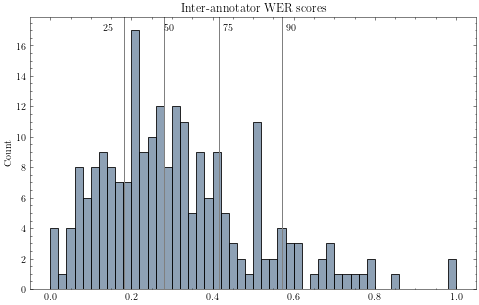

In [35]:
plt.figure(figsize=(8,5))

wer_describe = english_clips["inter_annotator_wer"].describe()

sns.histplot(english_clips["inter_annotator_wer"].values, bins=50)
plt.axvline(wer_describe["25%"], color='gray')
plt.text(wer_describe["25%"]-0.05, 17, '25%')
plt.axvline(wer_describe["50%"], color='gray')
plt.text(wer_describe["50%"], 17, '50%')
plt.axvline(wer_describe["75%"], color='gray')
plt.text(wer_describe["75%"]+0.01, 17, '75%')

plt.axvline(english_clips["inter_annotator_wer"].quantile(0.9), color='gray')
plt.text(english_clips["inter_annotator_wer"].quantile(0.9)+0.01, 17, '90%')

plt.title('Inter-annotator WER scores')
plt.show()

In [36]:
ninety_quantile = english_clips["inter_annotator_wer"].quantile(0.9)
ninety_quantile, len(english_clips), len(english_clips[english_clips["inter_annotator_wer"] > ninety_quantile])



(0.5714285714285714, 221, 21)

In [37]:
len(english_clips[english_clips["inter_annotator_wer"] > ninety_quantile]), \
len(english_clips[english_clips["inter_annotator_wer"] <= ninety_quantile])


(21, 200)

In [38]:
# Only keep clips were inter-annotator WER is within the 90th quantile
# Discard rows with inter-annotator agreement higher than certain threshold
english_clips = english_clips[english_clips["inter_annotator_wer"] <= ninety_quantile]
print(len(english_clips))

200


**TODO**: Need to discard the rows of human transcriptions that have inter-annotator agreement higher than a certain threshold

In [39]:
english_clips.country.value_counts()

Nigeria         63
South Africa    63
Namibia         57
Kenya           17
Name: country, dtype: int64

## WER Scores for ASRs

In this case, we are comparing everything against `human1` as the ground truth. 

#### WER - lower is better, 1 is bad

In [40]:
# for func_name, func in zip(["wer", "mer", "wil"], [calc_wer, calc_mer, calc_wil]):
#     for i, ground_truth in enumerate(["transcription_human1", "transcription_human2"]):
#         english_clips[f"riva_{i+1}_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_riva"), axis=1)
#         english_clips[f"ds_{i+1}_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_deepspeech"), axis=1)
#         english_clips[f"aws_{i+1}_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_aws"), axis=1)

for func_name, func in zip(["wer", "mer", "wil"], [calc_wer, calc_mer, calc_wil]):
    ground_truth = "transcription_human1"
    english_clips[f"riva_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_riva"), axis=1)
    english_clips[f"ds_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_deepspeech"), axis=1)
    english_clips[f"aws_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_aws"), axis=1)
    english_clips[f"human2_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_human2"), axis=1)


        

In [41]:
english_clips[["riva_wer", "ds_wer", "aws_wer", "human2_wer"]].mean(axis=0)

riva_wer      0.286578
ds_wer        0.554533
aws_wer       0.258148
human2_wer    0.269570
dtype: float64

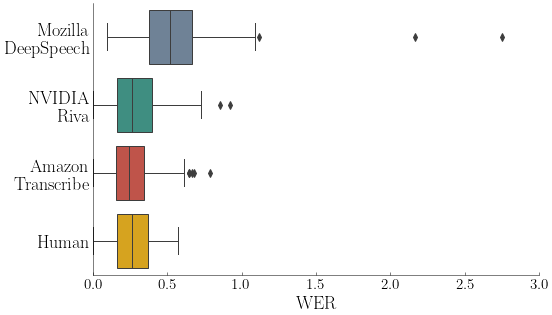

In [146]:
plt.figure(figsize=(8,5))

data = english_clips[[ "ds_wer", "riva_wer","aws_wer", "human2_wer"]]
data.columns = ["DeepSpeech", "Riva", "AWS", "Human2"]
data = data.melt(value_vars = ["DeepSpeech", "Riva", "AWS", "Human2"])
data.columns=["Model", "WER"]

ax = sns.boxplot(data=data, y='Model', x='WER')
# plt.title('Word Error Rate (WER) Distribution', size=16)
plt.ylabel('')
plt.xlabel('WER', size=18)
plt.xticks(size=15)
plt.yticks(ticks=[0,1,2,3], 
           labels=['Mozilla\nDeepSpeech', 'NVIDIA\nRiva', 'Amazon\nTranscribe', 'Human'],
           size=18
          )

# Remove spines
sns.despine(top=True, right=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)

plt.xlim(0,3)

# plt.show()
plt.savefig('img/WER_distribution.pdf', bbox_inches='tight') 
plt.savefig('img/WER_distribution.png', bbox_inches='tight') 


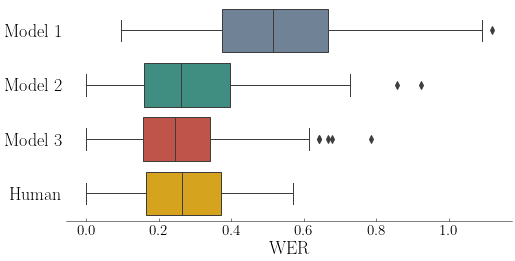

In [53]:
# THIS IS FOR THE BLOG POST ONLY
plt.figure(figsize=(8,4))

data = english_clips[[ "ds_wer", "riva_wer","aws_wer", "human2_wer"]]
data.columns = ["DeepSpeech", "Riva", "AWS", "Human2"]
data = data.melt(value_vars = ["DeepSpeech", "Riva", "AWS", "Human2"])
data.columns=["Model", "WER"]

# REMOVING OUTLIERS
data = data[data.WER < 2]

ax = sns.boxplot(data=data, y='Model', x='WER')
# plt.title('Word Error Rate (WER) Distribution', size=16)
plt.ylabel('')
plt.xlabel('WER', size=18)
plt.xticks(size=15)
plt.yticks(ticks=[0,1,2,3], 
           labels=['Model 1', 'Model 2', 'Model 3', 'Human'],
           size=18
          )

# Remove spines
sns.despine(top=True, right=True, left=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)

# plt.show()
# plt.savefig('img/blogpost_WER_distribution_anon.pdf', bbox_inches='tight') 
plt.savefig('img/blogpost_WER_distribution_anon.png', bbox_inches='tight') 


In [144]:
english_clips[["riva_wer", "ds_wer", "aws_wer", "human2_wer"]].describe()

,riva_wer,ds_wer,aws_wer,human2_wer
count,200.000000,199.000000,200.000000,200.000000
mean,0.286578,0.554533,0.258148,0.269570
std,0.165468,0.284887,0.151245,0.138670
min,0.000000,0.096774,0.000000,0.000000
25%,0.160000,0.375000,0.156250,0.165541
50%,0.260870,0.521739,0.245000,0.264912
75%,0.397170,0.666667,0.343054,0.371083
max,0.923077,2.750000,0.785714,0.571429


## ASRs Accuracy on COVID words
There may be a lot of empty strings bc a lot of these are not actually about covid

This may not actually be worth it and maybe WER is fine

In [149]:
t_cols = ["transcription_human1", "transcription_human2", 
          "transcription_riva", "transcription_aws", "transcription_deepspeech", ]

covid_words = ["covid", "corona", "vaccine", "vaccination", "pandemic", "quarantine", "virus", "disease",
               "clot", "infect"
              ]

# Less interesting words: "side effect", "delta", "variant"

In [180]:
covid_word_counts = []
for w in covid_words:
    # a subset of if human1 found the word 
    subset = english_clips[english_clips["transcription_human1"].str.contains(w)][t_cols]

    for t in t_cols:
        covid_word_counts.append({
            "word": w,
            "model": t.split("_")[1],
            "count": subset[t].str.count(w).sum()
        })
    

In [181]:
covid_word_counts_df = pd.DataFrame(covid_word_counts)


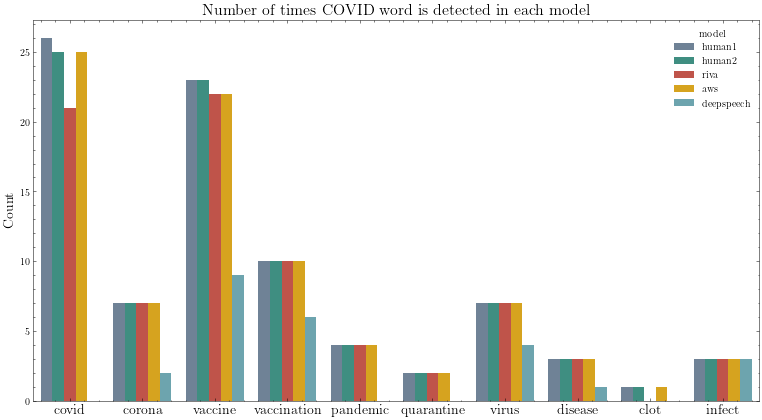

In [152]:
plt.figure(figsize=(13,7))
sns.barplot(data=covid_word_counts_df, x='word', y='count', hue='model')
plt.xticks(size=14)
plt.xlabel('')
plt.ylabel('Count', size=14)
plt.title('Number of times COVID word is detected in each model', size=16)
plt.show()

In [183]:
covid_word_counts_pivot = covid_word_counts_df.pivot(index='word', columns='model', values='count')
covid_word_counts_pivot.columns.name = None

ground_truth = covid_word_counts_pivot["human1"].values
covid_word_counts_pivot = covid_word_counts_pivot[["deepspeech", "riva", "aws", "human2"]]

In [184]:
covid_word_counts_pivot.apply(lambda x: x/ground_truth).T

word,clot,corona,covid,disease,infect,pandemic,quarantine,vaccination,vaccine,virus
deepspeech,0.0,0.285714,0.000000,0.333333,1.0,0.0,0.0,0.6,0.391304,0.571429
riva,0.0,1.000000,0.807692,1.000000,1.0,1.0,1.0,1.0,0.956522,1.000000
aws,1.0,1.000000,0.961538,1.000000,1.0,1.0,1.0,1.0,0.956522,1.000000
human2,1.0,1.000000,0.961538,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000


In [155]:
data = covid_word_counts_pivot.apply(lambda x: x/ground_truth).T

In [156]:
from IPython.core.display import display, HTML
output = data.to_html(formatters={
    'clot': '{:,.2%}'.format,
    'corona': '{:,.2%}'.format,
    'covid': '{:,.2%}'.format,
    'disease': '{:,.2%}'.format,
    'infect': '{:,.2%}'.format,
    'pandemic': '{:,.2%}'.format,
    'quarantine': '{:,.2%}'.format,
    'vaccination': '{:,.2%}'.format,
    'vaccine': '{:,.2%}'.format,
    'virus': '{:,.2%}'.format,
})
display(HTML(output))

word,clot,corona,covid,disease,infect,pandemic,quarantine,vaccination,vaccine,virus
deepspeech,0.00%,28.57%,0.00%,33.33%,100.00%,0.00%,0.00%,60.00%,39.13%,57.14%
riva,0.00%,100.00%,80.77%,100.00%,100.00%,100.00%,100.00%,100.00%,95.65%,100.00%
aws,100.00%,100.00%,96.15%,100.00%,100.00%,100.00%,100.00%,100.00%,95.65%,100.00%
human2,100.00%,100.00%,96.15%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


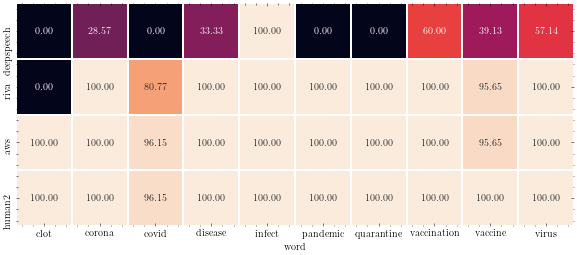

In [157]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(data, annot=True, fmt=".2%", square=1, linewidth=1., cbar=False)
plt.show()